In [13]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
from feature_extraction import OCR_raw_data, OCR_feature_data, face_raw_data, face_feature_data

Perceptron Model for OCR and Face Detection

In [14]:
class Perceptron:
    def __init__(self, input_size, output_size):
        # Initialize the weights and bias
        self.weights = np.zeros((output_size, input_size))
        self.bias = np.zeros(output_size)
        self.model = (self.weights, self.bias) # model is a tuple of weights and bias
    def train(self, X, y):
            correctTrain = 0
            weights = self.model[0]
            bias = self.model[1]
            for i in range(X.shape[0]): #iterate through each image
                # Forward pass
                weighted_sum = np.dot(self.weights,X[i]) + self.bias
                # make prediction
                if len(weighted_sum) == 2:
                    prediction = 1 if weighted_sum[1] > 0.5 else 0
                else:
                    prediction = np.argmax(weighted_sum)
                # Backward pass
                if y[i] != prediction:
                    weights[prediction, :] -= X[i]
                    bias[prediction] -= 1
                    weights[y[i], :] += X[i]
                    bias[y[i]] += 1
                else:
                     correctTrain += 1 # if prediction correct, increment correctTrain
            acc = correctTrain / X.shape[0]
            self.weights = weights
            self.bias = bias
            self.model = (self.weights, self.bias) # update the model
            return acc, self.model
            
    # Function to predict the output
    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            weighted_sum = np.dot(self.weights, X[i]) + self.bias
            if len(weighted_sum) == 2:
                    prediction = 1 if weighted_sum[1] > 0.5 else 0
            else:
                prediction = np.argmax(weighted_sum)
            predictions.append(prediction)
        return predictions

Select Training Data Helper Function
Given n, which is a value in the training sets array [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], finds number of rows/images to use from the training set through n*number of row. Finds a random assortment of indicies that is the length of number of images needed(n* total number of rows). Use selected indicies to return x, which is a random assortment of images, and y, which is the respective labels of the random assortment of images.

In [15]:
def process_data(xTrain, yTrain, n):
    num_rows = xTrain.shape[0]
    num_select =  int(num_rows*n)
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    x = [xTrain[index] for index in selected_indices]
    y = [yTrain[index] for index in selected_indices]
    xTrain = np.array(x)
    yTrain = np.array(y)
    return xTrain, yTrain

OnePerceptronSet
A single iteration of training, validating, and testing. Takes in training(xTrain, yTrain), validating(xValid, yValid), and testing(xTest, yTest) data as input. As well as the input layer size, the output layer size, the number max number of epochs to train for, the percentage of the training set to use (n) and an early abandoning of 3 epochs of no growth.

In [16]:

def OnePerceptronSet(n, input_size, output_size, epochs,X_tr,Y_tr, X_v,Y_v, X_te,Y_te, abandon):
    import time as time
    X, Y = process_data(X_tr, Y_tr,n) # Process the data
    ocr_perceptron = Perceptron(input_size, output_size) # Initialize the perceptron
    validAcc = []
    models = []
    max = 0
    maxCount = 0
    start_time = time.time() # Start the timer
    for i in range(epochs): 
        trainAcc, model = ocr_perceptron.train(X, Y) # Train the perceptron
        models.append(model) # Save the model
        vali_predictions = ocr_perceptron.predict(X_v) #
        #calculate the accuracy
        CorrectPredictionCount = 0
        for j in range(len(vali_predictions)):
            if vali_predictions[j] == Y_v[j]:
                CorrectPredictionCount += 1
        vali_Ocr_Accuracy = CorrectPredictionCount/len(vali_predictions)
        validAcc.append(vali_Ocr_Accuracy) # Save the accuracy
        # Early stopping
        if  validAcc[i] > max :
            max = validAcc[i]
            maxCount = 0
        else:
            maxCount += 1
        if maxCount == abandon:
            break
        print(f'Epoch {i+1}/{epochs} - Training Accuracy: {trainAcc*100:.2f}% - Validation Accuracy: {vali_Ocr_Accuracy*100:.2f}%')
    end_time = time.time() # End the timer
    elasped_time = end_time - start_time # Calculate the time taken
    best_model = models[np.argmax(validAcc)] # Get the best model
    ocr_perceptron.model = best_model # Set the best model
    test_predictions = ocr_perceptron.predict(X_te) # Test the model
    #calculate the accuracy
    CorrectPredictionCount = 0
    for i in range(len(test_predictions)):
        if test_predictions[i] == Y_te[i]:
            CorrectPredictionCount += 1
    test_Accuracy = CorrectPredictionCount/len(test_predictions)
    print(f'Test Accuracy: {test_Accuracy*100:.2f}%')

    return elasped_time, test_Accuracy, ocr_perceptron




In [17]:
training_sets = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]

Digit Classification

Get training, validating, and testing data. Use raw pixel data as features.

In [18]:
OCRtrainImg = "digitdata/trainingimages"
OCRtrainLabel = "digitdata/traininglabels"

OCRvalidImg = "digitdata/validationimages"
OCRvalidLabel = "digitdata/validationlabels"

OCRtestImg = "digitdata/testimages"
OCRtestLabel = "digitdata/testlabels"

X_train_Ocr, Y_train_Ocr = OCR_raw_data(OCRtrainImg, OCRtrainLabel)
X_valid_Ocr, Y_valid_Ocr = OCR_raw_data(OCRvalidImg, OCRvalidLabel)
X_test_Ocr, Y_test_Ocr = OCR_raw_data(OCRtestImg, OCRtestLabel)

print(X_train_Ocr.shape)
print(len(Y_train_Ocr))
print(X_valid_Ocr.shape)
print(len(Y_valid_Ocr))
print(X_test_Ocr.shape)
print(len(Y_test_Ocr))


(5000, 784)
5000
(1000, 784)
1000
(1000, 784)
1000


Train, validate and test on the training set sizes. Perform 10 iterations at each training set. Find the mean and standard deviation of the accuracies at each training set as well as the mean time it took to train at each training set. Store the models from each iteration. Plot mean accuracies, standard deviation of accuracies, and mean elasped times for each training set.

Training Set Size: 10%
Iteration 1/10
Epoch 1/20 - Training Accuracy: 54.60% - Validation Accuracy: 65.50%
Epoch 2/20 - Training Accuracy: 78.60% - Validation Accuracy: 67.90%
Epoch 3/20 - Training Accuracy: 88.80% - Validation Accuracy: 71.30%
Epoch 4/20 - Training Accuracy: 91.20% - Validation Accuracy: 66.50%
Epoch 5/20 - Training Accuracy: 92.80% - Validation Accuracy: 71.50%
Epoch 6/20 - Training Accuracy: 94.40% - Validation Accuracy: 71.90%
Epoch 7/20 - Training Accuracy: 97.00% - Validation Accuracy: 73.10%
Epoch 8/20 - Training Accuracy: 96.20% - Validation Accuracy: 72.60%
Epoch 9/20 - Training Accuracy: 95.60% - Validation Accuracy: 72.70%
Test Accuracy: 70.20%

Iteration 2/10
Epoch 1/20 - Training Accuracy: 57.60% - Validation Accuracy: 55.50%
Epoch 2/20 - Training Accuracy: 80.60% - Validation Accuracy: 66.70%
Epoch 3/20 - Training Accuracy: 89.20% - Validation Accuracy: 67.50%
Epoch 4/20 - Training Accuracy: 91.40% - Validation Accuracy: 67.90%
Epoch 5/20 - Training Accur

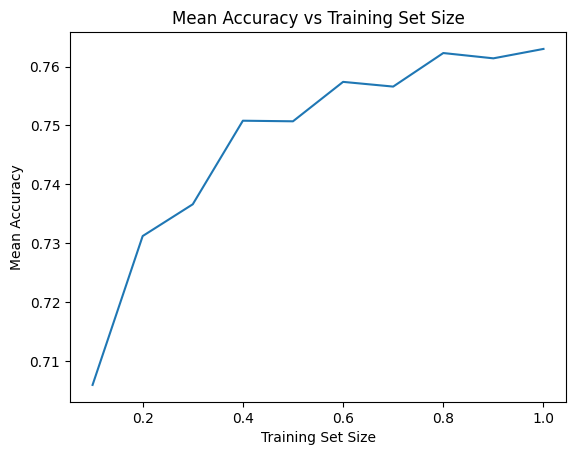

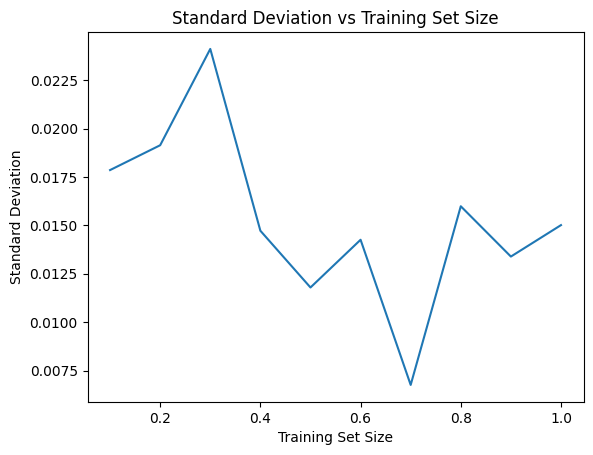

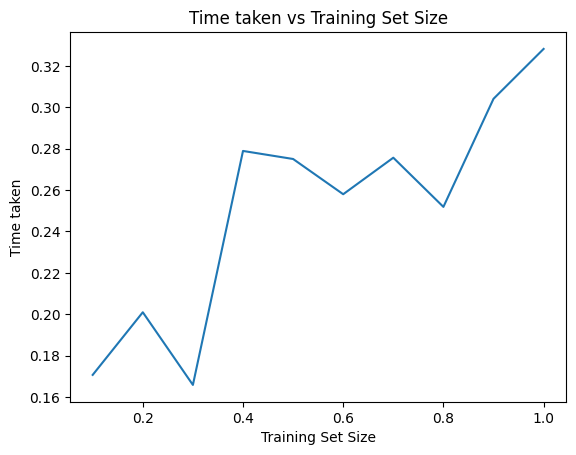

In [29]:
timesOcrArr = []
meanAccOcrArr = []
stdAccOcrArr = []
perceptronsOCR = []
for i in training_sets:
    setTimes = []
    setAcc = []
    print(f'Training Set Size: {i*100:.0f}%')
    for j in range(10):
        print(f'Iteration {j+1}/10')
        time,acc, ocrPerceptron=OnePerceptronSet(i, 784, 10, 20, X_train_Ocr, Y_train_Ocr, X_valid_Ocr, Y_valid_Ocr, X_test_Ocr, Y_test_Ocr, 3)
        setTimes.append(time)
        setAcc.append(acc)
        perceptronsOCR.append(ocrPerceptron)
        print("")
    meanTimes = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTimes:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesOcrArr.append(meanTimes)
    meanAccOcrArr.append(meanAcc)
    stdAccOcrArr.append(stdAcc)
plt.plot(training_sets, meanAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time taken')
plt.title('Time taken vs Training Set Size')
plt.show()

Demo

In [59]:
xDemoTest_OCR, yDemoTest_OCR = process_data(X_test_Ocr, Y_test_Ocr, 1.0)
demoTestPredictions = perceptronsOCR[-1].predict(xDemoTest_OCR)
CorrectPredictionCount = 0
for k in range(len(demoTestPredictions)):
    if demoTestPredictions[k] == yDemoTest_OCR[k]:
        CorrectPredictionCount += 1
test_Accuracy = CorrectPredictionCount/len(demoTestPredictions)
print(f'Test Accuracy: {test_Accuracy*100:.2f}%')

index = 0
demoPrediction = demoTestPredictions[index]
demoTruth = yDemoTest_OCR[index]
print(f'Demo Prediction: {demoPrediction} - Demo Truth: {demoTruth}')


Test Accuracy: 77.90%
Demo Prediction: 9 - Demo Truth: 9


Face Detection

Get training, validating, and testing data. Use raw pixel data as features.

In [24]:
FacetrainImg = "facedata/facedatatrain"
FacetrainLabel = "facedata/facedatatrainlabels"

FacevalidImg = "facedata/facedatavalidation"
FacevalidLabel = "facedata/facedatavalidationlabels"

FacetestImg = "facedata/facedatatest"
FacetestLabel = "facedata/facedatatestlabels"

X_train_face, Y_train_face = face_raw_data(FacetrainImg, FacetrainLabel)
X_valid_face, Y_valid_face = face_raw_data(FacevalidImg, FacevalidLabel)
X_test_face, Y_test_face = face_raw_data(FacetestImg, FacetestLabel)

print(X_train_face.shape)
print(len(Y_train_face))
print(X_valid_face.shape)
print(len(Y_valid_face))
print(X_test_face.shape)
print(len(Y_test_face))

(451, 4200)
451
(301, 4200)
301
(150, 4200)
150


Same as Digit Classification
Train, validate and test on the training set sizes. Perform 10 iterations at each training set. Find the mean and standard deviation of the accuracies at each training set as well as the mean time it took to train at each training set. Store the models from each iteration. Plot mean accuracies, standard deviation of accuracies, and mean elasped times for each training set.

Training set size: 10%
Iteration 1/10
Epoch 1/20 - Training Accuracy: 64.44% - Validation Accuracy: 71.76%
Epoch 2/20 - Training Accuracy: 75.56% - Validation Accuracy: 74.42%
Epoch 3/20 - Training Accuracy: 93.33% - Validation Accuracy: 58.80%
Epoch 4/20 - Training Accuracy: 95.56% - Validation Accuracy: 64.78%
Test Accuracy: 76.00%

Iteration 2/10
Epoch 1/20 - Training Accuracy: 60.00% - Validation Accuracy: 62.79%
Epoch 2/20 - Training Accuracy: 91.11% - Validation Accuracy: 67.77%
Epoch 3/20 - Training Accuracy: 91.11% - Validation Accuracy: 68.11%
Epoch 4/20 - Training Accuracy: 100.00% - Validation Accuracy: 68.11%
Epoch 5/20 - Training Accuracy: 100.00% - Validation Accuracy: 68.11%
Test Accuracy: 71.33%

Iteration 3/10
Epoch 1/20 - Training Accuracy: 64.44% - Validation Accuracy: 63.12%
Epoch 2/20 - Training Accuracy: 91.11% - Validation Accuracy: 64.78%
Epoch 3/20 - Training Accuracy: 95.56% - Validation Accuracy: 65.12%
Epoch 4/20 - Training Accuracy: 100.00% - Validation Acc

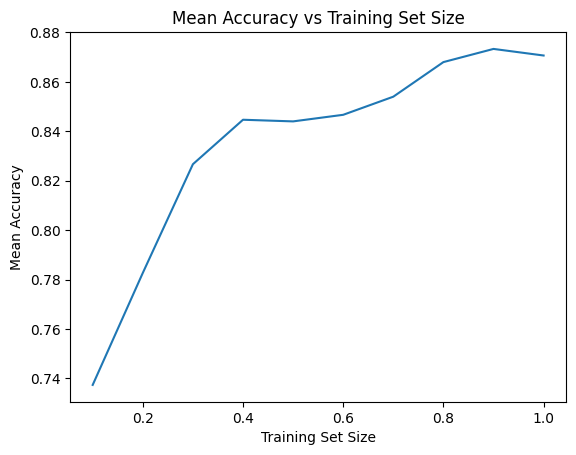

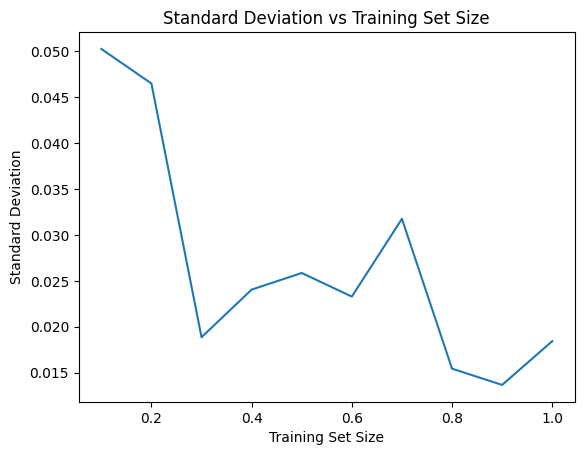

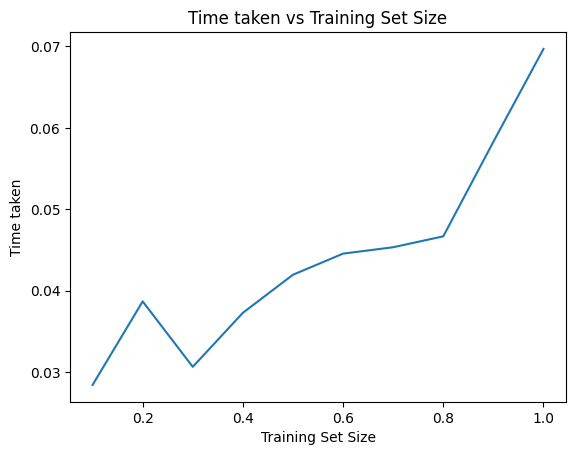

In [28]:
timesFaceArr = []
meanAccFaceArr = []
stdAccFaceArr = []
perceptronsFace = []
for i in training_sets:
    print(f'Training set size: {i*100:.0f}%')
    setTimes = []
    setAcc = []
    for j in range(10):
        print(f'Iteration {j+1}/10')
        time, acc, perceptronF=OnePerceptronSet(i, 70*60, 2, 20, X_train_face, Y_train_face, X_valid_face, Y_valid_face, X_test_face, Y_test_face, 3)
        setTimes.append(time)
        setAcc.append(acc)
        perceptronsFace.append(perceptronF)
        print("")
    meanTimes = np.mean(setTimes)
    meanAcc = np.mean(setAcc)
    stdAcc = np.std(setAcc)
    print(f'Mean Time: {meanTimes:.2f} seconds - Mean Accuracy: {meanAcc*100:.2f}% - Standard Deviation: {stdAcc*100:.2f}%')
    timesFaceArr.append(meanTimes)
    meanAccFaceArr.append(meanAcc)
    stdAccFaceArr.append(stdAcc)

plt.plot(training_sets, meanAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time taken')
plt.title('Time taken vs Training Set Size')
plt.show()



Demo

In [46]:
xDemoTest_Face, yDemoTest_Face = process_data(X_test_face, Y_test_face, 1.0)
demoTestPredictions = perceptronsFace[-1].predict(xDemoTest_Face)
CorrectPredictionCount = 0
for k in range(len(demoTestPredictions)):
    if demoTestPredictions[k] == yDemoTest_Face[k]:
        CorrectPredictionCount += 1
test_Accuracy = CorrectPredictionCount/len(demoTestPredictions)
print(f'Test Accuracy: {test_Accuracy*100:.2f}%')

index = 0
demoPrediction = demoTestPredictions[index]
demoTruth = yDemoTest_Face[index]
print(f'Demo Prediction: {demoPrediction} - Demo Truth: {demoTruth}')

Test Accuracy: 84.00%
Demo Prediction: 0 - Demo Truth: 0
